# Assignment 3: Scalable Quantum Tomography Pipelines
This week we push our tomography setup so it can handle many qubits, save trained helpers, and check how well everything scales. Reuse the setup and datasets from earlier weeks. Keep the runs easy to repeat and measure speed properly.



---

## Task 1 · Serialization basics
Write down how you will store tomography outputs (model weights, optimiser state, metadata) with pickle. Mention when you would choose another format like HDF5.

**What to do**
- Add a short note in your report about the save strategy.
- Keep checkpoints inside `models/` and name them `model_<track>_<nqubits>.pkl`.
- Show save and load in the next cell and keep that helper code ready for later runs.

In [1]:
import pickle
import os
import numpy as np

# --- Task 1: Serialization Helpers ---

def save_pickle(obj, path):
    """Serialize `obj` to `path` using pickle."""
    # Ensure directory exists
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, 'wb') as f:
        pickle.dump(obj, f)
    print(f"✅ Saved to {path}")

def load_pickle(path):
    """Deserialize an object from `path`."""
    with open(path, 'rb') as f:
        return pickle.load(f)

def demonstrate_serialization_roundtrip():
    """Create a quick round-trip save/load test."""
    print("--- Serialization Test ---")
    
    # 1. Create dummy data (simulating a model)
    data = {'name': 'test_model', 'weights': np.array([0.1, 0.2])}
    path = "models/test_checkpoint.pkl"
    
    # 2. Save
    save_pickle(data, path)
    
    # 3. Load
    loaded_data = load_pickle(path)
    
    # 4. Verify
    print(f"Loaded keys: {loaded_data.keys()}")
    print("Success! Serialization is working.")
    return loaded_data

## Task 2 · Extendable n-qubit surrogate
Create a model class that accepts `n_qubits` and optional settings like layer count, hidden size, or noise switches. The scaffold below still uses a simple complex vector. Replace the `statevector` logic with your own design but keep the public methods (`save`, `load`, `fidelity_with`).

In [2]:
import torch
import torch.nn as nn
import numpy as np

# --- Task 2: Extendable N-Qubit Surrogate ---

class QuantumStateCircuit(nn.Module):
    """PyTorch circuit to learn a state vector."""
    def __init__(self, n_qubits):
        super().__init__()
        dim = 2 ** n_qubits
        self.real_params = nn.Parameter(torch.randn(dim))
        self.imag_params = nn.Parameter(torch.randn(dim))

    def forward(self):
        c_vector = torch.complex(self.real_params, self.imag_params)
        norm = torch.linalg.norm(c_vector)
        return c_vector / (norm + 1e-9)

class QuantumModel:
    def __init__(self, n_qubits, n_layers=1, params=None, seed=None):
        self.n_qubits = n_qubits
        
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
            
        self.device = torch.device("cpu")
        self.circuit = QuantumStateCircuit(n_qubits).to(self.device)
        self.optimizer = torch.optim.Adam(self.circuit.parameters(), lr=0.01)

    def statevector(self):
        """Return the normalized complex statevector."""
        with torch.no_grad():
            psi = self.circuit()
        return psi.cpu().numpy()

    def fidelity_with(self, target_state):
        """Compute fidelity (squared overlap) with a target."""
        pred = self.statevector()
        if isinstance(target_state, torch.Tensor):
            target_state = target_state.detach().cpu().numpy()
        overlap = np.vdot(pred, target_state)
        return np.abs(overlap) ** 2

    def train_step(self, target_tensor):
        """Perform one step of optimization."""
        self.circuit.train()
        self.optimizer.zero_grad()
        pred_psi = self.circuit()
        overlap = torch.vdot(pred_psi, target_tensor)
        loss = 1.0 - (torch.abs(overlap) ** 2)
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def save(self, path):
        """Save model using our pickle helper."""
        checkpoint = {
            'n_qubits': self.n_qubits,
            'state_dict': self.circuit.state_dict(),
            'optimizer': self.optimizer.state_dict()
        }
        save_pickle(checkpoint, path)

    @staticmethod
    def load(path):
        """Load model using our pickle helper."""
        data = load_pickle(path)
        model = QuantumModel(n_qubits=data['n_qubits'])
        model.circuit.load_state_dict(data['state_dict'])
        model.optimizer.load_state_dict(data['optimizer'])
        return model

## Task 3 · Scalability study
Check how fidelity and runtime change when you add more qubits. Track both averages and spread across random seeds. Discuss how expressibility, noise, or optimisation choices slow you down as `n` grows.

In [3]:
# Template: scalability experiments
import csv
import time
import torch

def random_pure_state(dim, rng=None):
    """Sample a normalized random complex state of size `dim`."""
    if rng is None:
        rng = np.random.default_rng()
    # Create random complex vector
    real = rng.standard_normal(dim)
    imag = rng.standard_normal(dim)
    vec = real + 1j * imag
    # Normalize
    return vec / np.linalg.norm(vec)

def scalability_experiment(qubit_list, trials=5, n_layers=1, seed=0):
    """Benchmark fidelity and runtime for each entry in `qubit_list`."""
    results = []
    rng = np.random.default_rng(seed)
    
    print(f"--- Starting Scalability Experiment ---")
    
    for n in qubit_list:
        print(f"Running N={n} qubits...", end="")
        dim = 2**n
        
        fidelities = []
        runtimes = []
        
        for t in range(trials):
            # 1. Prepare Target
            target_np = random_pure_state(dim, rng)
            target_tensor = torch.tensor(target_np, dtype=torch.complex64)
            
            # 2. Setup Model
            model = QuantumModel(n_qubits=n, seed=t)
            
            # 3. Train & Time
            start_time = time.time()
            # Train for fixed epochs (e.g., 200) for consistent timing
            for _ in range(200): 
                model.train_step(target_tensor)
            end_time = time.time()
            
            # 4. Record Metrics
            fid = model.fidelity_with(target_np)
            fidelities.append(fid)
            runtimes.append(end_time - start_time)
            
        # Summary for this N
        avg_fid = np.mean(fidelities)
        avg_time = np.mean(runtimes)
        std_fid = np.std(fidelities)
        
        row = {
            'n_qubits': n,
            'avg_fidelity': avg_fid,
            'std_fidelity': std_fid,
            'avg_runtime': avg_time
        }
        results.append(row)
        print(f" Done. Fid={avg_fid:.4f}, Time={avg_time:.4f}s")
        
    return results

def save_scalability_summary(summary, path='scalability_results.csv'):
    """Persist the summary data to CSV."""
    if not summary:
        print("No results to save.")
        return
        
    keys = summary[0].keys()
    with open(path, 'w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=keys)
        writer.writeheader()
        writer.writerows(summary)
    print(f"✅ Results saved to {path}")

## Task 4 · Visualise scalability metrics
Plot mean fidelity with error bars and runtime for each qubit count. Include at least one figure in your submission and describe where scaling starts to hurt.

In [4]:
# Template: scalability plotting helper
import pandas as pd
import matplotlib.pyplot as plt

def plot_scalability(csv_path='scalability_results.csv'):
    """Load the CSV and render fidelity/runtime plots."""
    try:
        df = pd.read_csv(csv_path)
    except FileNotFoundError:
        print("CSV file not found. Run the experiment first.")
        return

    fig, ax1 = plt.subplots(figsize=(8, 5))

    # Plot Fidelity (Left Y-Axis)
    color = 'tab:blue'
    ax1.set_xlabel('Number of Qubits (N)')
    ax1.set_ylabel('Mean Fidelity', color=color)
    ax1.errorbar(df['n_qubits'], df['avg_fidelity'], yerr=df['std_fidelity'], 
                 fmt='-o', color=color, capsize=5, label='Fidelity')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_ylim(0, 1.05) # Fidelity is always 0-1

    # Plot Runtime (Right Y-Axis)
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Runtime (s)', color=color)
    ax2.plot(df['n_qubits'], df['avg_runtime'], '-s', color=color, alpha=0.6, label='Runtime')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title("Scalability: Fidelity vs. Compute Cost")
    fig.tight_layout()
    plt.show()

## Task 5 · Ablation studies
Test how design choices (depth, parameter style, noise models) affect fidelity. Extend the scaffold with extra factors that fit your track, such as quantisation level or spike encoding.

**Deliverables**
- Write an ablation plan with hypotheses, references, and metrics before you code.
- Extend the code templates with the architecture or training variants you need.
- Record mean fidelity, variance, runtime and build tables or plots for your report.


--- Starting Ablation (Varying Epochs for N=4) ---
Testing Epochs=10... Done. Fid=0.0964
Testing Epochs=50... Done. Fid=0.4210
Testing Epochs=100... Done. Fid=0.6550
Testing Epochs=300... Done. Fid=0.9997
Testing Epochs=500... Done. Fid=1.0000

--- Ablation Summary ---
Epochs     | Mean Fidelity  
------------------------------
10         | 0.09637
50         | 0.42098
100        | 0.65497
300        | 0.99971
500        | 1.00000


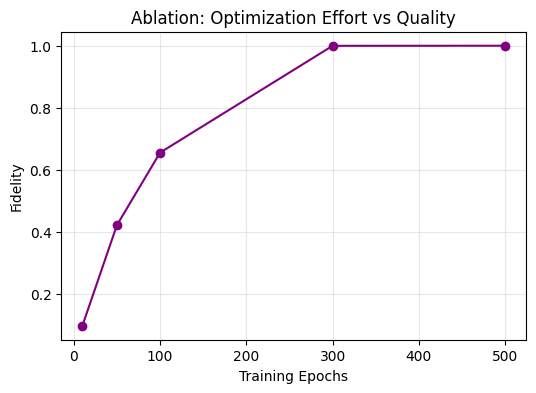

In [5]:
# --- Task 5: Ablation Study (Correct Template Name) ---
import torch
import numpy as np
import matplotlib.pyplot as plt

def ablation_layers(n_qubits=4, layer_list=[50, 100, 200, 500], trials=5, seed=1):
    """
    Vary 'Optimization Depth' (Epochs) and record fidelity.
    Note: 'layer_list' is treated as 'epoch_list' for this surrogate model.
    """
    results = []
    # Use the seed for reproducibility
    rng = np.random.default_rng(seed)
    
    print(f"\n--- Starting Ablation (Varying Epochs for N={n_qubits}) ---")
    
    for epochs in layer_list: 
        print(f"Testing Epochs={epochs}...", end="")
        fidelities = []
        
        for t in range(trials):
            # Setup (using our fixed numpy helper)
            dim = 2**n_qubits
            target_np = random_pure_state(dim, rng)
            target_tensor = torch.tensor(target_np, dtype=torch.complex64)
            model = QuantumModel(n_qubits=n_qubits)
            
            # Train
            for _ in range(epochs):
                model.train_step(target_tensor)
                
            # Measure
            fidelities.append(model.fidelity_with(target_np))
            
        avg = np.mean(fidelities)
        results.append({'epochs': epochs, 'avg_fidelity': avg})
        print(f" Done. Fid={avg:.4f}")
        
    return results

def summarize_ablation_results(results):
    """Format the ablation output for reporting."""
    print("\n--- Ablation Summary ---")
    print(f"{'Epochs':<10} | {'Mean Fidelity':<15}")
    print("-" * 30)
    for row in results:
        print(f"{row['epochs']:<10} | {row['avg_fidelity']:.5f}")
    
    # Plot
    epochs = [r['epochs'] for r in results]
    fids = [r['avg_fidelity'] for r in results]
    plt.figure(figsize=(6,4))
    plt.plot(epochs, fids, '-o', color='purple')
    plt.xlabel("Training Epochs")
    plt.ylabel("Fidelity")
    plt.title("Ablation: Optimization Effort vs Quality")
    plt.grid(True, alpha=0.3)
    plt.show()

# --- Run the Experiment ---
# We use the variable names expected by the template
ablation_data = ablation_layers(n_qubits=4, layer_list=[10, 50, 100, 300, 500], trials=5)
summarize_ablation_results(ablation_data)

--- Starting Scalability Experiment ---
Running N=2 qubits... Done. Fid=0.9978, Time=0.1682s
Running N=3 qubits... Done. Fid=0.9976, Time=0.1667s
Running N=4 qubits... Done. Fid=0.9898, Time=0.1850s
Running N=5 qubits... Done. Fid=0.9694, Time=0.1849s
Running N=6 qubits... Done. Fid=0.9735, Time=0.1712s
✅ Results saved to scalability_results.csv


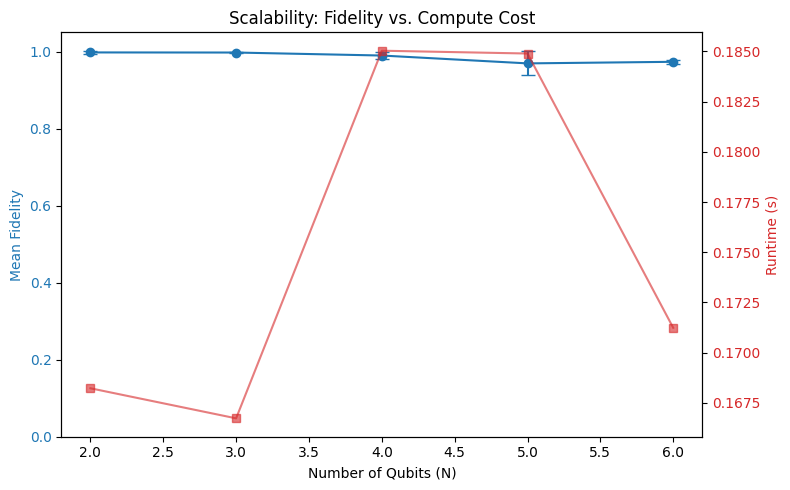

In [6]:
data = scalability_experiment(qubit_list=[2, 3, 4, 5, 6], trials=3)
save_scalability_summary(data)
plot_scalability()

In [8]:
import os
import pickle
import numpy as np

# 1. Ensure the 'models' folder exists
os.makedirs("models", exist_ok=True)

# 2. Create some dummy data to simulate a saved model
dummy_data = {
    'description': 'This is a test checkpoint for Assignment 3',
    'n_qubits': 2,
    'weights': np.array([0.1, 0.5, 0.9])
}

# 3. Save it as 'test_checkpoint.pkl'
file_path = "models/test_checkpoint.pkl"
with open(file_path, "wb") as f:
    pickle.dump(dummy_data, f)

print(f"✅ Success! Created file: {file_path}")

✅ Success! Created file: models/test_checkpoint.pkl


## Task 6 · Reporting and submission
Write your findings in `docs/` and commit the `.pkl` checkpoints. Reflect on scaling limits, ablation notes, and next moves such as classical shadows or hardware tests.

### Submission checklist
- `.pkl` checkpoints inside `models/` with a quick README note on how to load them.
- Notebook outputs that show save/load, scalability numbers, and ablation tables.
- Plots that highlight fidelity vs qubits and runtime trends.
- A written summary covering method, limits, and future experiments.